#### This program uses images of lung x-rays to diagnose verious lung diseases. The model is trained to recognize that a lung is either healthy or sick with Covid-19, pneumonia, or tuberculosis. When radiologists are unavailable (which is too often the case), a program like this can be integrated into an app for a quick diagnosis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

path = Path.cwd()/r'OneDrive\Desktop\Datasets\lung_xray'
train_image_dir = path/'train'
validation_image_dir = path/'validation'

,Train,Validation
COVID19,7.67%,24.76%
NORMAL,22.11%,24.76%
PNEUMONIA,60.75%,25.24%
TURBERCULOSIS,9.47%,25.24%


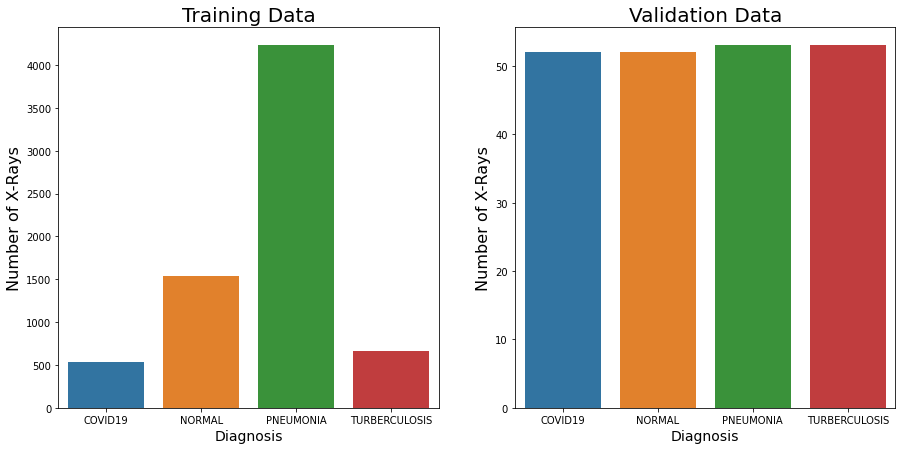

In [2]:
dirs = os.listdir(train_image_dir)

train_total = 0
val_total = 0

train_list = [0,0,0,0]
val_list = [0,0,0,0]

train_dict = {}
val_dict = {}

data = [[train_image_dir,train_total,train_list],
       [validation_image_dir,val_total,val_list]]

for i in range(len(data)):
    for d in range(len(dirs)):
        file = data[i][0]/dirs[d]
        num = len(os.listdir(file))
        data[i][1] += num
        data[i][2][d] += num
    
ds = [train_dict,val_dict]

for d in range(len(ds)):
    for i in range(len(dirs)):
        ds[d].setdefault(dirs[i],data[d][2][i]/data[d][1])
        
train_stats = ds[0].values()
val_stats = ds[1].values()

stats = pd.DataFrame({'Train':train_stats,'Validation':val_stats},index=dirs)
stats['Train'] = stats['Train'].map(lambda x: '{:.2%}'.format(x))
stats['Validation'] = stats['Validation'].map(lambda x: '{:.2%}'.format(x))

display(stats)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.barplot(x=list(stats.index),y=data[0][2])
plt.title('Training Data',fontdict={'fontsize':20})
plt.ylabel('Number of X-Rays',fontdict={'fontsize':16})
plt.xlabel('Diagnosis',fontdict={'fontsize':14})
plt.subplot(1,2,2)
sns.barplot(x=stats.index,y=data[1][2])
plt.title('Validation Data',fontdict={'fontsize':20})
plt.ylabel('Number of X-Rays',fontdict={'fontsize':16})
plt.xlabel('Diagnosis',fontdict={'fontsize':14})
plt.show()

In [3]:
train_data_gen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=10,
                                   width_shift_range=15,
                                   shear_range=.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=.3,
                                   height_shift_range=.2)

batch_size = 24
img_height = 256
img_width = 256

training_images = train_data_gen.flow_from_directory(train_image_dir,
                                                    target_size=(img_height,img_width),
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

val_data_gen = ImageDataGenerator(rescale=1/255)

validation_images = val_data_gen.flow_from_directory(validation_image_dir,
                                                    target_size=(img_height,img_width),
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

Found 6960 images belonging to 4 classes.
Found 210 images belonging to 4 classes.


#### The model is trained using nearly 7,000 images. A number of examples are displayed below. I can't really tell the difference between them, but hopefully the neural network will.

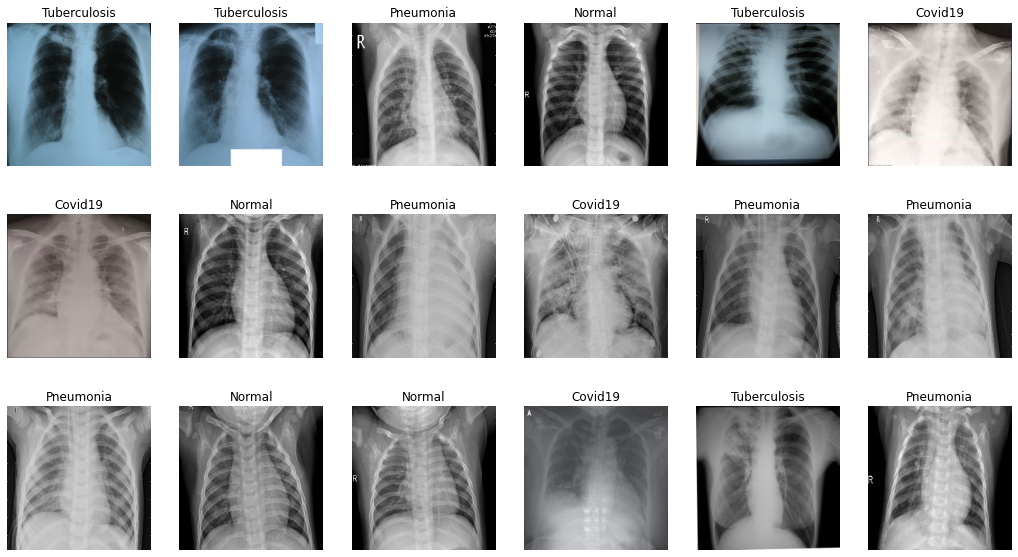

In [4]:
label_names = ['Covid19','Normal','Pneumonia','Tuberculosis']

plt.figure(figsize=(18,10))
for i in range(18):
    batch_num = random.randint(0,len(validation_images)-1)
    batch = validation_images[batch_num]
    img_num = random.randint(0,len(batch[0])-1)
    image = batch[0][img_num]
    label = label_names[int(np.argmax(batch[1][img_num]))]
    plt.subplot(3,6,i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
plt.show()

#### The model uses a number of convolutional and pooling layers to break down the images into their most significant features, followed by dense layers. It uses L2 and dropout regularization and the adam optimizer with a dynamically tuned learning rate

In [5]:
l2 = keras.regularizers.L2(.01)
input_shape = (img_height,img_width,3)
dropout_rate = .2


inputs = keras.Input(shape=input_shape)

X = keras.layers.Conv2D(24,(3,3),activation='elu',kernel_regularizer=l2)(inputs)
X = keras.layers.MaxPooling2D(2)(X)

X = keras.layers.Conv2D(48,(3,3),activation='elu',kernel_regularizer=l2)(X)
X = keras.layers.MaxPooling2D(2)(X)

X = keras.layers.Conv2D(96,(3,3),activation='elu',kernel_regularizer=l2)(X)
X = keras.layers.MaxPooling2D(2)(X)

X = keras.layers.Conv2D(192,(3,3),activation='elu',kernel_regularizer=l2)(X)
X = keras.layers.MaxPooling2D(2)(X)

X = keras.layers.Conv2D(384,(3,3),activation='elu',kernel_regularizer=l2)(X)
X = keras.layers.MaxPooling2D(2)(X)

X = keras.layers.Flatten()(X)

X = keras.layers.Dense(350,activation='relu',kernel_regularizer=l2)(X)
X = keras.layers.Dropout(dropout_rate)(X)

X = keras.layers.Dense(350,activation='relu',kernel_regularizer=l2)(X)
X = keras.layers.Dropout(dropout_rate)(X)

outputs = keras.layers.Dense(4,activation='softmax')(X)


lung_xray_model = keras.Model(inputs=inputs,
                             outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss = keras.losses.CategoricalCrossentropy()

lung_xray_model.compile(optimizer=optimizer,
             loss=loss,
             metrics=['accuracy'])

lung_xray_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 24)      672       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 48)      10416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 96)        41568     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 96)        0     

In [6]:
epochs = 12

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=3,
                                              restore_best_weights=True,
                                              min_delta=.005,
                                              verbose=1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                             patience=1,
                                             verbose=1,
                                             factor=.5,
                                             min_delta=.008)

model_history = lung_xray_model.fit(training_images,
                                   validation_data=validation_images,
                                   verbose=2,
                                   epochs=epochs,
                                   callbacks=[early_stopping,
                                             reduce_lr])

Epoch 1/12
290/290 - 504s - loss: 9.0177 - accuracy: 0.6553 - val_loss: 5.2675 - val_accuracy: 0.7333
Epoch 2/12
290/290 - 481s - loss: 3.9365 - accuracy: 0.7543 - val_loss: 3.4966 - val_accuracy: 0.4952

Epoch 00002: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 3/12
290/290 - 470s - loss: 2.7858 - accuracy: 0.7987 - val_loss: 2.7104 - val_accuracy: 0.7048
Restoring model weights from the end of the best epoch.

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 00003: early stopping


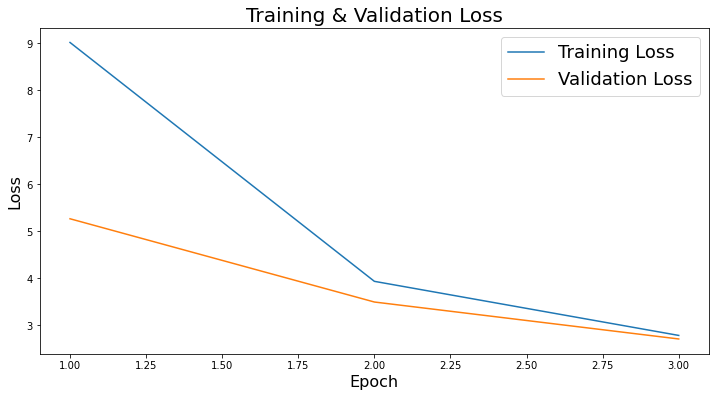

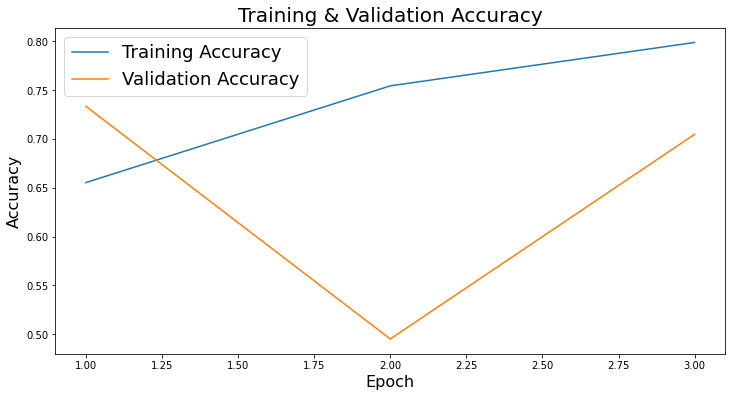

In [7]:
hist = model_history.history

loss = hist['loss']
accuracy = hist['accuracy']
val_loss = hist['val_loss']
val_acc = hist['val_accuracy']

epoch = np.arange(1,len(loss)+1,1)

plt.figure(figsize=(12,6))
plt.plot(epoch,loss)
plt.plot(epoch,val_loss)
plt.title('Training & Validation Loss',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':16})
plt.ylabel('Loss',fontdict={'fontsize':16})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=(12,6))
plt.plot(epoch,accuracy)
plt.plot(epoch,val_acc)
plt.title('Training & Validation Accuracy',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':16})
plt.ylabel('Accuracy',fontdict={'fontsize':16})
plt.legend(['Training Accuracy','Validation Accuracy'],prop={'size':18})
plt.show()

#### Finally, the neural network will look at a number of images and determine a diagnosis.

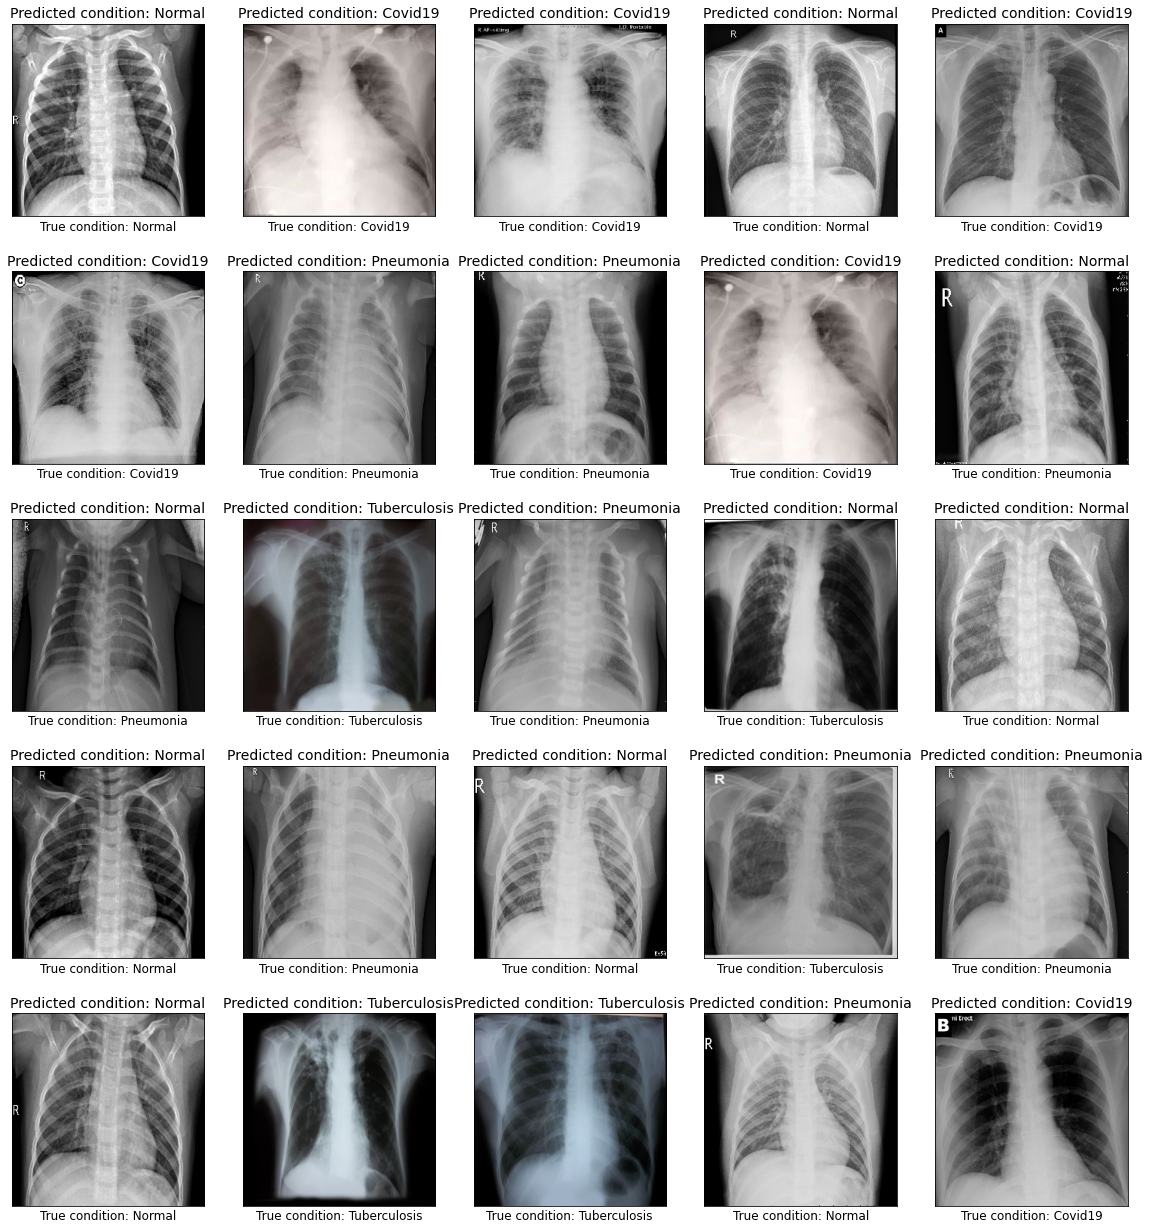

In [8]:
plt.figure(figsize=(20,22))
for i in range(25):
    
    batch_num = random.randint(0,len(validation_images)-1)
    batch = validation_images[batch_num]
    image_num = random.randint(0,len(batch[0])-1)
    image = batch[0][image_num]
    true_label = np.argmax(batch[1][image_num])
    true_label = label_names[true_label]
    prediction = lung_xray_model.predict(tf.expand_dims(image,axis=0)).argmax()
    predicted_label = label_names[prediction]
    title = 'Predicted condition: {}'.format(predicted_label)
    xlabel = 'True condition: {}'.format(true_label)
    
    plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(title,fontdict={'fontsize':14})
    plt.xlabel(xlabel,fontdict={'fontsize':12})
    plt.xticks(())
    plt.yticks(())
plt.show()